In [1]:
!lscpu |grep 'Model name'
!nvidia-smi
!pip install ax-platform

Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Mon Mar 20 06:25:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [2]:
import pandas as pd
from ax import *
import torch

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner
from ax.metrics.noisy_function import GenericNoisyFunctionMetric

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from botorch.test_functions.multi_objective import DTLZ3

In [3]:
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [4]:
dim = 30
problem = DTLZ3(num_objectives=2, dim=dim, negate=False).to(**tkwargs)

param_names = [f"x{i}" for i in range(dim)]

def f1(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names] # Obtiene los parámetros a evaluar
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[0]) # Evalúa los parámetros en el primer objetivo
    
def f2(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names]
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[1]) # Evalúa los parámetros en el segundo objetivo

metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name=param_name, lower=0, upper=1, parameter_type=ParameterType.FLOAT)
        for param_name in param_names
        ]
)

mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [6]:
N_INIT = 2 * (dim + 1)
N_BATCH = 10
BATCH_SIZE = 1

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

In [7]:
import time

executions = 10
execution_times = []
all_df = []
all_outcomes = []

for exec in range(executions):
  start_time = time.time()

  experiment = build_experiment()
  data = initialize_experiment(experiment)

  hv_list = []
  model = None
  for i in range(N_BATCH):   
      model = Models.FULLYBAYESIANMOO(
          experiment=experiment, 
          data=data,
          num_samples=16,
          warmup_steps=32,
          torch_device=tkwargs["device"],
      )
      generator_run = model.gen(BATCH_SIZE)
      trial = experiment.new_trial(generator_run=generator_run)
      trial.run()
      data = Data.from_multiple_data([data, trial.fetch_data()])
      
      exp_df = exp_to_df(experiment)
      outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
      try:
          hv = observed_hypervolume(modelbridge=model)
      except:
          hv = 0
          print("Failed to compute hv")
      hv_list.append(hv)
      print(f"Execution: {exec + 1}, Iteration: {i + 1}, HV: {hv}")

  execution_times.append(time.time() - start_time)

  all_df.append(exp_to_df(experiment).sort_values(by=["trial_index"]))
  all_outcomes.append(np.array(exp_to_df(experiment)[['a', 'b']], dtype=np.double))

Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=2.25e-01, acc. prob=0.961]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 1, HV: 94618584.650249


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=5.34e-01, acc. prob=0.145]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 2, HV: 97244925.1052756


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=3.37e-01, acc. prob=0.887]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 3, HV: 98452889.24586083


Sample: 100%|██████████| 48/48 [00:18,  2.64it/s, step size=4.81e-01, acc. prob=0.228]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 4, HV: 98452889.24586083


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=4.24e-01, acc. prob=0.857]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 5, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=2.83e-01, acc. prob=0.893]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 6, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=3.63e-01, acc. prob=0.465]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 7, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=3.28e-01, acc. prob=0.898]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 8, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:22,  2.16it/s, step size=3.07e-01, acc. prob=0.836]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 9, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:19,  2.49it/s, step size=6.27e-01, acc. prob=0.059]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 10, HV: 98774670.47010417


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=4.53e-01, acc. prob=0.602]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 1, HV: 93826229.27506793


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=6.28e-01, acc. prob=0.176]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 2, HV: 95053397.38047133


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=3.55e-01, acc. prob=0.420]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 3, HV: 96838735.48198622


Sample: 100%|██████████| 48/48 [00:14,  3.22it/s, step size=5.01e-01, acc. prob=0.106]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 4, HV: 97518958.87990221


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=2.01e-01, acc. prob=0.949]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 5, HV: 97518958.87990221


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=2.99e-01, acc. prob=0.930]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 6, HV: 97518958.87990221


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=1.51e-01, acc. prob=0.968]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 7, HV: 97914927.0531036


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=5.28e-01, acc. prob=0.113]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 8, HV: 97914927.0531036


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=2.04e-01, acc. prob=0.945]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 9, HV: 98937776.68419081


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=3.86e-01, acc. prob=0.801]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 10, HV: 98937776.68419081


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.62e-01, acc. prob=0.822]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 1, HV: 94839344.08774367


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=3.42e-01, acc. prob=0.396]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 2, HV: 96934418.40238531


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=5.12e-01, acc. prob=0.398]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 3, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:11,  4.14it/s, step size=6.89e-01, acc. prob=0.036]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 4, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=3.19e-01, acc. prob=0.173]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 5, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=3.76e-01, acc. prob=0.816]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 6, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=2.51e-01, acc. prob=0.767]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 7, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=2.30e-01, acc. prob=0.911]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 8, HV: 98914037.35406196


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=3.14e-01, acc. prob=0.758]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 9, HV: 99283522.80602317


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=3.73e-01, acc. prob=0.690]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 10, HV: 99283522.80602317


Sample: 100%|██████████| 48/48 [00:13,  3.43it/s, step size=6.02e-01, acc. prob=0.204]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 1, HV: 93473190.87911932


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=5.73e-01, acc. prob=0.161]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 2, HV: 95844229.84984446


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=4.72e-01, acc. prob=0.230]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 3, HV: 97221739.58778095


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=5.06e-01, acc. prob=0.273]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 4, HV: 97221739.58778095


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=4.91e-01, acc. prob=0.429]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 5, HV: 98655240.50575416


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=2.28e-01, acc. prob=0.585]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 6, HV: 98655240.50575416


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=3.66e-01, acc. prob=0.501]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 7, HV: 98655240.50575416


Sample: 100%|██████████| 48/48 [00:20,  2.38it/s, step size=1.36e-01, acc. prob=0.914]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 8, HV: 98655240.50575416


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=3.37e-01, acc. prob=0.853]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 9, HV: 98655240.50575416


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=3.59e-01, acc. prob=0.732]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 10, HV: 98899645.06310087


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=4.75e-01, acc. prob=0.216]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 1, HV: 93490229.72438923


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=2.74e-01, acc. prob=0.875]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 2, HV: 97439426.98784164


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=3.94e-01, acc. prob=0.646]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 3, HV: 98805595.9250834


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.83e-01, acc. prob=0.895]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 4, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=5.39e-01, acc. prob=0.239]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 5, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:20,  2.33it/s, step size=4.17e-01, acc. prob=0.734]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 6, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=4.41e-01, acc. prob=0.568]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 7, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=2.04e-01, acc. prob=0.743]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 8, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=4.69e-01, acc. prob=0.538]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 9, HV: 99368337.59103325


Sample: 100%|██████████| 48/48 [00:21,  2.19it/s, step size=4.51e-01, acc. prob=0.591]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 10, HV: 99476644.03626919


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=3.49e-01, acc. prob=0.683]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 1, HV: 93207123.62328209


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=2.50e-01, acc. prob=0.951]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 2, HV: 96611936.33600064


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=1.61e-01, acc. prob=0.910]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 3, HV: 96901303.49668479


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=2.72e-01, acc. prob=0.880]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 4, HV: 96926215.49518403


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=2.88e-01, acc. prob=0.801]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 5, HV: 98300979.92003365


Sample: 100%|██████████| 48/48 [00:18,  2.64it/s, step size=4.26e-01, acc. prob=0.234]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 6, HV: 98300979.92003365


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.50e-01, acc. prob=0.741]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 7, HV: 98300979.92003365


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=2.44e-01, acc. prob=0.806]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 8, HV: 98389754.42997724


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=3.45e-01, acc. prob=0.689]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 9, HV: 98775553.88100258


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=5.08e-01, acc. prob=0.205]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 10, HV: 98775553.88100258


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=3.80e-01, acc. prob=0.559]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 1, HV: 93278532.35176168


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=3.72e-01, acc. prob=0.697]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 2, HV: 97324788.85615627


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=1.42e-01, acc. prob=0.633]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 3, HV: 97695743.9228558


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=4.12e-01, acc. prob=0.760]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 4, HV: 97695743.9228558


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.68e-01, acc. prob=0.801]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 5, HV: 99354356.33312066


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=4.16e-01, acc. prob=0.730]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 6, HV: 99354356.33312066


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.88e-01, acc. prob=0.929]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 7, HV: 99354356.33312066


Sample: 100%|██████████| 48/48 [00:10,  4.39it/s, step size=3.99e-01, acc. prob=0.054]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 8, HV: 99354356.33312066


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=3.48e-01, acc. prob=0.862]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 9, HV: 99354356.33312066


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=3.01e-01, acc. prob=0.452]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 10, HV: 99362170.72367667


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=2.57e-01, acc. prob=0.408]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 1, HV: 93551797.70090677


Sample: 100%|██████████| 48/48 [00:18,  2.63it/s, step size=4.43e-01, acc. prob=0.652]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 2, HV: 95245159.44722411


Sample: 100%|██████████| 48/48 [00:20,  2.37it/s, step size=3.13e-01, acc. prob=0.807]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 3, HV: 96578579.5639013


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.00e-01, acc. prob=0.800]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 4, HV: 96578579.5639013


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=4.56e-01, acc. prob=0.531]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 5, HV: 96637093.14732385


Sample: 100%|██████████| 48/48 [00:19,  2.51it/s, step size=5.76e-01, acc. prob=0.303]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 6, HV: 97271436.55033289


Sample: 100%|██████████| 48/48 [00:21,  2.25it/s, step size=4.37e-01, acc. prob=0.615]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 7, HV: 97652446.44579048


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=3.85e-01, acc. prob=0.241]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 8, HV: 98465922.13598889


Sample: 100%|██████████| 48/48 [00:20,  2.31it/s, step size=3.69e-01, acc. prob=0.733]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 9, HV: 98465922.13598889


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=5.32e-01, acc. prob=0.265]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 10, HV: 98919270.71599491


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=4.89e-01, acc. prob=0.216]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 1, HV: 93708453.00012164


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=1.47e-01, acc. prob=0.949]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 2, HV: 95302359.6079788


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=7.43e-02, acc. prob=0.931]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 3, HV: 95544390.0414412


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=1.71e-01, acc. prob=0.945]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 4, HV: 96467821.46052374


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=3.85e-01, acc. prob=0.777]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 5, HV: 97364182.07754847


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=2.37e-01, acc. prob=0.055]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 6, HV: 97364182.07754847


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=2.93e-01, acc. prob=0.923]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 7, HV: 98860512.4830934


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=3.52e-01, acc. prob=0.785]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 8, HV: 98860512.4830934


Sample: 100%|██████████| 48/48 [00:21,  2.26it/s, step size=3.52e-01, acc. prob=0.852]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 9, HV: 98860512.4830934


Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=4.01e-01, acc. prob=0.542]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 10, HV: 98860512.4830934


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=7.40e-02, acc. prob=0.956]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 1, HV: 93872599.33460027


Sample: 100%|██████████| 48/48 [00:22,  2.16it/s, step size=4.10e-01, acc. prob=0.759]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 2, HV: 96614600.49192065


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=5.38e-01, acc. prob=0.176]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 3, HV: 97958903.84187338


Sample: 100%|██████████| 48/48 [00:14,  3.39it/s, step size=5.76e-01, acc. prob=0.138]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 4, HV: 97958903.84187338


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=2.76e-01, acc. prob=0.637]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 5, HV: 97958903.84187338


Sample: 100%|██████████| 48/48 [00:21,  2.18it/s, step size=2.78e-01, acc. prob=0.921]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 6, HV: 97958903.84187338


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=2.61e-01, acc. prob=0.902]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 7, HV: 97958903.84187338


Sample: 100%|██████████| 48/48 [00:22,  2.14it/s, step size=3.23e-01, acc. prob=0.689]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 8, HV: 98187456.79675783


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.02e-01, acc. prob=0.839]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 9, HV: 98187456.79675783


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.41e-01, acc. prob=0.801]


Execution: 10, Iteration: 10, HV: 98187456.79675783


/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


<ipython-input-8-fd334caa4d76>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


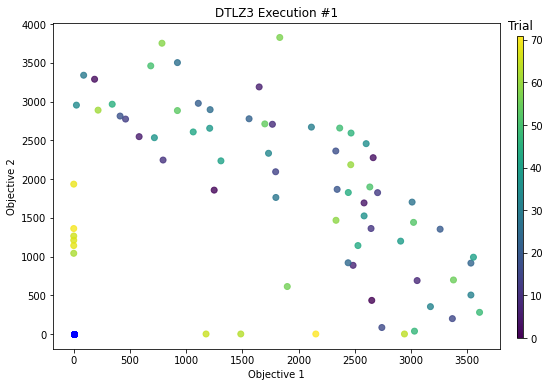

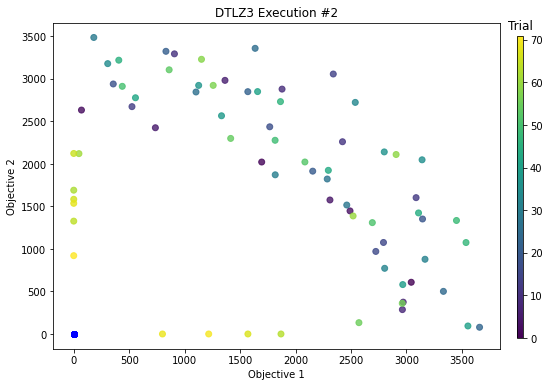

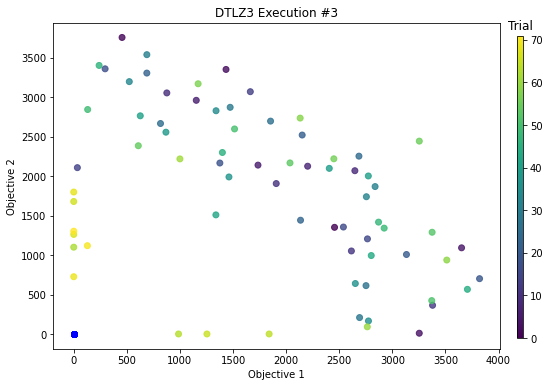

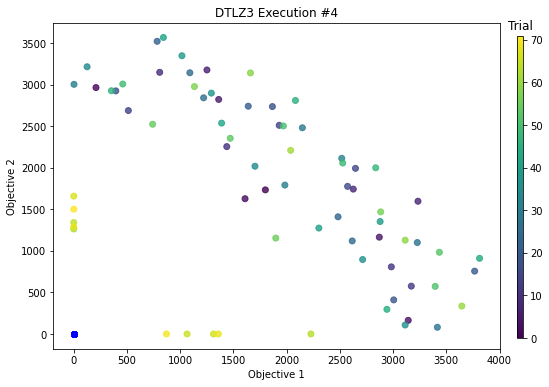

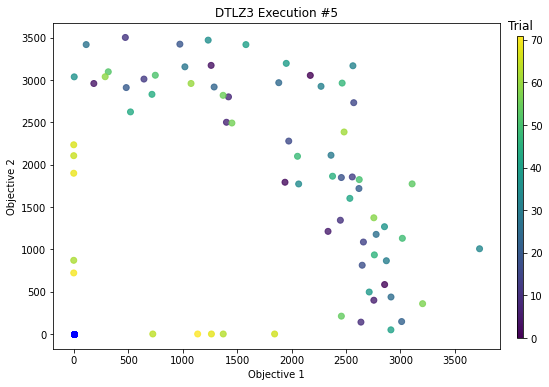

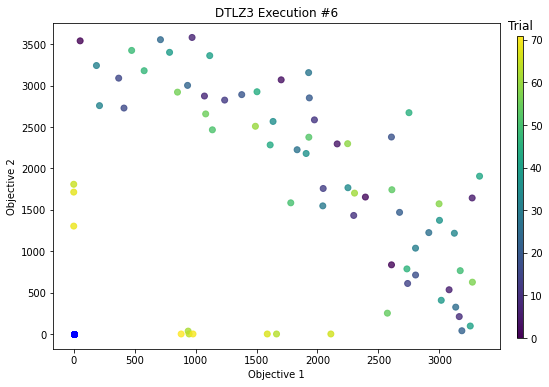

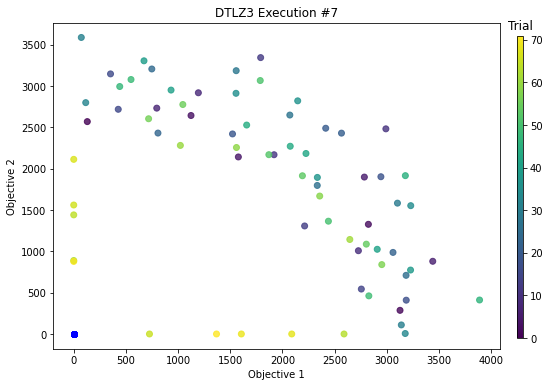

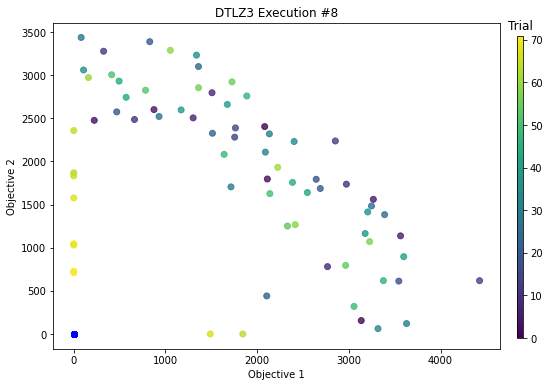

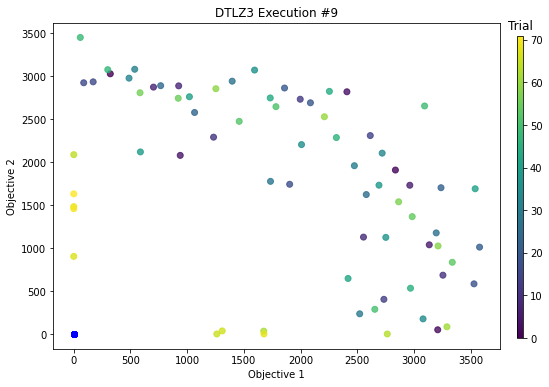

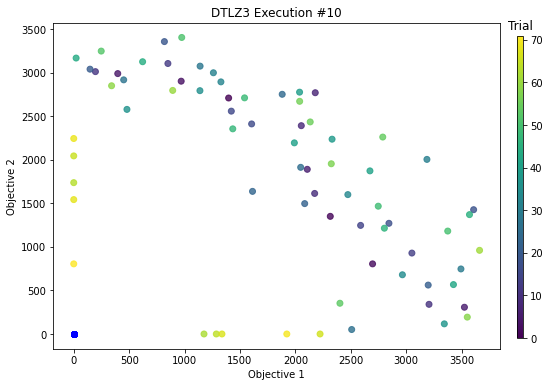

In [8]:
from torch import Tensor
%matplotlib inline

for exec in range(executions):
  fig, axes = plt.subplots(1, 1, figsize=(8,6))

  pareto_front = Tensor.cpu(problem.gen_pareto_front(50))
  axes.scatter(pareto_front[:, 0], pareto_front[:, 1], color='b')


  cm = plt.cm.get_cmap('viridis')
  batch_number = all_df[exec].trial_index.values
  sc = axes.scatter(all_outcomes[exec][:, 0], all_outcomes[exec][:,1], c=batch_number, alpha=0.8)
  axes.set_title(f'DTLZ3 Execution #{exec + 1}')
  axes.set_xlabel("Objective 1")
  axes.set_ylabel("Objective 2")
  norm = plt.Normalize(batch_number.min(), batch_number.max())
  sm =  ScalarMappable(norm=norm, cmap=cm)
  fig.subplots_adjust(right=0.9)
  cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.ax.set_title("Trial")

Execution times: [477.23052621 479.95163751 464.40183997 466.01222658 478.97856927
 489.08965206 466.842834   488.33797598 530.67270327 452.91376567]
Average execution time: 479.44317305088043


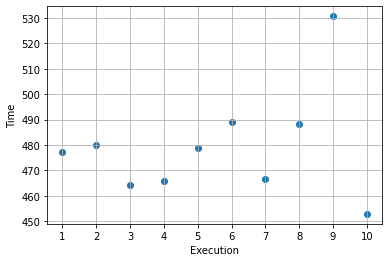

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
plt.xticks(np.arange(1, executions + 1))

axes.scatter(np.arange(1, executions + 1), np.array(execution_times))
axes.grid(True)
axes.set_xlabel("Execution")
axes.set_ylabel("Time")

print("Execution times:", np.array(execution_times))
print("Average execution time:", np.array(execution_times).sum()/len(execution_times))

In [10]:
print(all_df)

[    trial_index arm_name trial_status generation_method             a  \
0             0      0_0      RUNNING             Sobol  2.650541e+03   
1             1      1_0      RUNNING             Sobol  1.249033e+03   
2             2      2_0      RUNNING             Sobol  1.853403e+02   
3             3      3_0      RUNNING             Sobol  2.663154e+03   
4             4      4_0      RUNNING             Sobol  2.582047e+03   
..          ...      ...          ...               ...           ...   
67           67     67_0      RUNNING  FullyBayesianMOO  7.412979e-14   
68           68     68_0      RUNNING  FullyBayesianMOO  6.987031e-14   
69           69     69_0      RUNNING  FullyBayesianMOO  1.184326e-13   
70           70     70_0      RUNNING  FullyBayesianMOO  8.335504e-14   
71           71     71_0      RUNNING  FullyBayesianMOO  2.152997e+03   

              b  is_feasible        x0        x1        x2  ...       x20  \
0    433.555037         True  0.103219  0.109